In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime, timedelta
import gdal
import scipy as sp

import cartopy.crs as ccrs

In [2]:
s_time = datetime(2019,1,26,0)
e_time = datetime(2020,2,8,0)

#s_time = datetime(2019,6,6,0,0,0) -timedelta(hours=10)
#e_time = datetime(2019,6,11,0,0,0) -timedelta(hours=10)

lat0 = -10
lat1 = -30
lon0 = 135
lon1 = 154
res = 0.05

In [3]:
# path for HIMAWARI (after running Pablos algorthim to stack nc files)
path_him = '/g/data/oe9/user/ds4491/Him_Extract_Test/HIM8_TWNV_SE_2019.nc'
path_awap = '/g/data1a/oe9/user/data/gridded_rainfall_0.05deg/rain_day_2019_Actual_day.nc'

In [4]:
him = xr.open_dataset(path_him)

In [5]:
him.time.values

array([20190126.        , 20190126.        , 20190126.        ,
       20190126.04166667, 20190126.08333333, 20190126.125     ,
       20190126.16666667, 20190126.20833333, 20190126.25      ,
       20190126.25      , 20190126.25      , 20190126.29166667,
       20190126.33333333, 20190126.375     , 20190126.41666667,
       20190126.45833333, 20190126.5       , 20190126.5       ,
       20190126.5       , 20190126.54166667, 20190126.58333333,
       20190126.625     , 20190126.66666667, 20190126.70833333,
       20190126.75      , 20190126.75      , 20190126.75      ,
       20190126.79166667, 20190126.83333333, 20190126.875     ,
       20190126.91666667, 20190126.95833333, 20190127.        ,
       20190127.04166667, 20190127.08333333, 20190127.125     ,
       20190127.16666667, 20190127.20833333, 20190127.25      ,
       20190127.29166667, 20190127.33333333, 20190127.375     ,
       20190127.41666667, 20190127.45833333, 20190127.5       ,
       20190127.54166667, 20190127.58333

In [6]:
him['f1'] = (him['B14']<=230)
him['f2'] = (him['B8']-him['B12'])>= -10
him['mask_n'] = him['f1']*1 + him['f2']*1

In [7]:
him['f3'] = (him['B8']-him['B10'])>= -7
him['f4'] = (him['B16']-him['B14'])>= -5
him['mask_n'] = him['mask_n']*1 + him['f3']*1 + him['f4']*1

In [8]:
him['f5'] = (him['B15']-him['B14'])>= -1.5
him['f6'] = (him['B11']-him['B14'])>= 2
him['mask_n'] = him['mask_n']*1 + him['f5']*1 + him['f6']*1

In [9]:
him['f7'] = (((him['B8']+him['B13'])/2)-273) <= -35
him['mask_n'] = him['mask_n'] + him['f7']*1

In [10]:
him['mask']= him['mask_n']>=5

In [11]:
him

<xarray.Dataset>
Dimensions:  (lat: 1000, lon: 1000, time: 317)
Coordinates:
  * time     (time) float64 2.019e+07 2.019e+07 ... 2.019e+07 2.019e+07
  * lon      (lon) float64 135.0 135.0 135.1 135.1 ... 154.9 154.9 155.0 155.0
  * lat      (lat) float64 -10.01 -10.03 -10.05 -10.07 ... -29.95 -29.97 -29.99
Data variables:
    crs      int32 ...
    B8       (time, lat, lon) float32 ...
    B9       (time, lat, lon) float32 ...
    B10      (time, lat, lon) float32 ...
    B11      (time, lat, lon) float32 ...
    B12      (time, lat, lon) float32 ...
    B13      (time, lat, lon) float32 ...
    B14      (time, lat, lon) float32 221.70287 222.01085 ... 253.71068
    B15      (time, lat, lon) float32 ...
    B16      (time, lat, lon) float32 ...
    f1       (time, lat, lon) bool True True True True ... False False False
    f2       (time, lat, lon) bool True True True True ... True True True True
    mask_n   (time, lat, lon) int64 6 6 6 6 6 6 7 7 5 4 ... 0 1 2 2 2 2 2 2 2 2
    f3       (time, lat, lon) bool True True True True ... True True True True
    f4       (time, lat, lon) bool True True True True ... False False False
    f5       (time, lat, lon) bool True True True True ... False False False
    f6       (time, lat, lon) bool False False False False ... False False False
    f7       (time, lat, lon) bool True True True True ... False False False
    mask     (time, lat, lon) bool True True True True ... False False False
Attributes:
    CDI:          Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/...
    Conventions:  CF-1.5
    history:      Wed Feb 12 16:01:59 2020: cdo mergetime aux.nc batch.nc HIM...
    GDAL:         GDAL 2.2.2, released 2017/09/15
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/...

In [13]:
him2 = him.copy()
him2.time.values = np.floor(him2.time)
index_time = np.unique(him2.time.values, return_index=True)
him3=him2[['mask']].isel(time = index_time[1]).copy()

lat = him3['lat'].values
lon = him3['lon'].values
time = him3['time'].values

for ii in np.arange(len(him3.time.values)):    
    mask = np.any(np.stack(him2['mask'].sel(time=him3.time.values[ii]).values),axis = 0)
    if ii==0:
        mask_all = mask.copy()
        mask_all = np.expand_dims(mask_all,axis=0)
    else:
        mask = np.expand_dims( mask,axis=0)
        mask_all= np.append( mask_all,mask,axis=0)

him4 = xr.Dataset({'mask': (['time', 'lat', 'lon'],  mask_all)},coords={ 'lon': lon, 'lat': lat, 'time': time})
him4

<xarray.Dataset>
Dimensions:  (lat: 1000, lon: 1000, time: 13)
Coordinates:
  * lon      (lon) float64 135.0 135.0 135.1 135.1 ... 154.9 154.9 155.0 155.0
  * lat      (lat) float64 -10.01 -10.03 -10.05 -10.07 ... -29.95 -29.97 -29.99
  * time     (time) float64 2.019e+07 2.019e+07 ... 2.019e+07 2.019e+07
Data variables:
    mask     (time, lat, lon) bool True True True True ... True False False

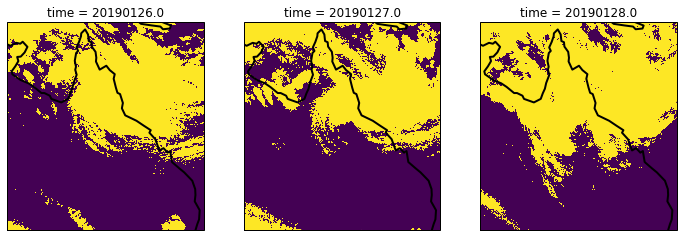

In [14]:
fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 3) # plot 3 axes along one row with three columns

# add first axis
ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())
him4['mask'].isel(time=0).plot(ax=ax1,transform=ccrs.PlateCarree(),add_colorbar=False) # don't plot colorbar
ax1.coastlines(linewidth=2); ax1.set_extent([lon0,lon1,lat1,lat0])

# add second axis
ax2 = fig.add_subplot(gs[0, 1],projection=ccrs.PlateCarree())
him4['mask'].isel(time=1).plot(ax=ax2,transform=ccrs.PlateCarree(),add_colorbar=False)
ax2.coastlines(linewidth=2); ax2.set_extent([lon0,lon1,lat1,lat0])

# add second axis
ax3 = fig.add_subplot(gs[0, 2],projection=ccrs.PlateCarree())
him4['mask'].isel(time=2).plot(ax=ax3,transform=ccrs.PlateCarree(),add_colorbar=False)
ax3.coastlines(linewidth=2); ax3.set_extent([lon0,lon1,lat1,lat0])

In [15]:
awap= xr.open_dataset(path_awap)
awap = awap.sel(time = slice(s_time+timedelta(days=1),e_time+timedelta(days=1)),latitude = slice(lat0,lat1),longitude= slice(lon0,lon1))
awap['rain_day'].isel(time=0)

<xarray.DataArray 'rain_day' (latitude: 401, longitude: 381)>
[152781 values with dtype=float32]
Coordinates:
    time       datetime64[ns] 2019-01-27
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 ... -29.9 -29.95 -30.0
  * longitude  (longitude) float64 135.0 135.1 135.1 135.2 ... 153.9 153.9 154.0
Attributes:
    name:           rain_day
    standard_name:  lwe_thickness_of_precipitation_amount
    long_name:      Daily Rainfall
    units:          mm

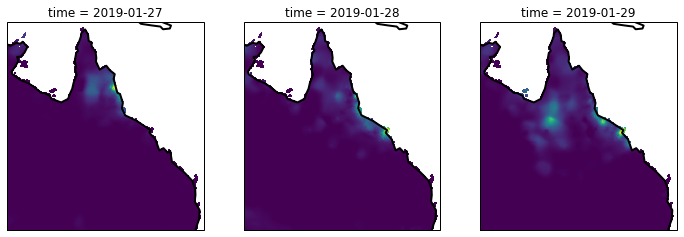

In [16]:
fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 3) # plot 3 axes along one row with three columns

# add first axis
ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())
awap['rain_day'].isel(time=0).plot(ax=ax1,transform=ccrs.PlateCarree(),add_colorbar=False) # don't plot colorbar
ax1.coastlines(linewidth=2); ax1.set_extent([lon0,lon1,lat1,lat0])

# add second axis
ax2 = fig.add_subplot(gs[0, 1],projection=ccrs.PlateCarree())
awap['rain_day'].isel(time=1).plot(ax=ax2,transform=ccrs.PlateCarree(),add_colorbar=False)
ax2.coastlines(linewidth=2); ax2.set_extent([lon0,lon1,lat1,lat0])

# add second axis
ax3 = fig.add_subplot(gs[0, 2],projection=ccrs.PlateCarree())
awap['rain_day'].isel(time=2).plot(ax=ax3,transform=ccrs.PlateCarree(),add_colorbar=False)
ax3.coastlines(linewidth=2); ax3.set_extent([lon0,lon1,lat1,lat0])

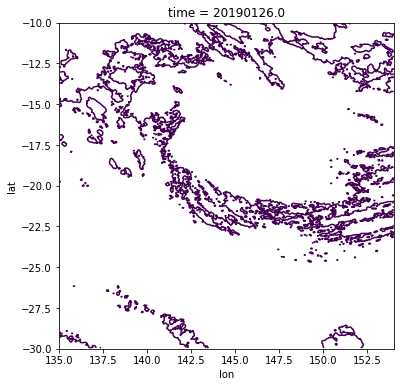

In [17]:
awap_lat = awap['latitude'].data
awap_lon = awap['longitude'].data

him4['mask']=him4['mask']*1
mask_resamp = him4.mask.interp(lat = awap_lat, lon = awap_lon)
mask_resamp.isel(time=0).plot.contour(levels=1,figsize=(6,6))

In [18]:
# make mask cmap
mask_cmap = colors.ListedColormap(['#FFFFFF00','#A9A9A910'])
bounds=np.arange(-1, 1, 2).tolist()

In [19]:
# resample mask
awap_lat = awap['latitude'].data
awap_lon = awap['longitude'].data
him4['mask']=him4['mask']*1
mask_resamp = him4.mask.interp(lat = awap_lat, lon = awap_lon)

In [20]:
import cartopy.feature as cfeature
def plot_timestep(i):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection=ccrs.PlateCarree())
    awap['rain_day'].isel(time=i).plot(ax=ax,transform=ccrs.PlateCarree(),cmap="Blues",\
                                   norm=colors.LogNorm(vmin=1,vmax=100),cbar_kwargs={"shrink":0.83}) # don't plot colorbar
    mask_resamp.isel(time=i).plot(ax=ax,transform=ccrs.PlateCarree(),cmap=mask_cmap,add_colorbar=False)
    mask_resamp.isel(time=i).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=1,colors="grey",linewidths=0.5)

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='black')
    ax.coastlines(linewidth=1)
    ax.set_extent([lon0,lon1,lat1,lat0])
    ax.set_xticks([i for i in np.arange(lon0,lon1,5)],crs=ccrs.PlateCarree())
    ax.set_yticks([i for i in np.arange(lat1,lat0,5)],crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude $(^\circ)$")
    ax.set_ylabel("Latitude $(^\circ)$")

/g/data/oe9/software/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


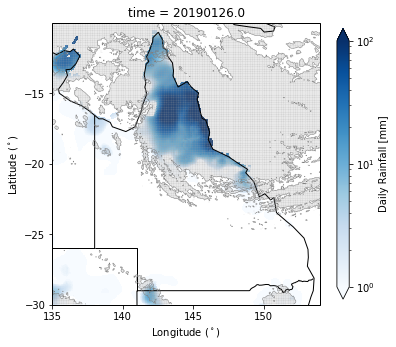

In [21]:
plot_timestep(0)

In [22]:
mask_resamp['time'].values

array([20190126., 20190127., 20190128., 20190129., 20190130., 20190131.,
       20190201., 20190202., 20190203., 20190204., 20190205., 20190206.,
       20190207.])

mkdir: cannot create directory `qld_anim/': File exists
0
1
2
3
4
5
6
7
8
9
10
11
12


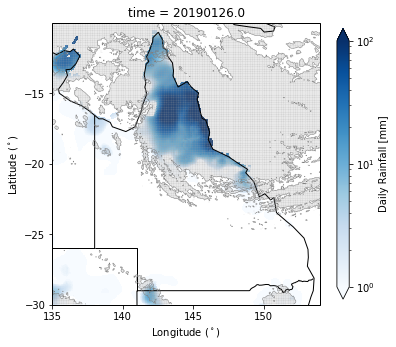

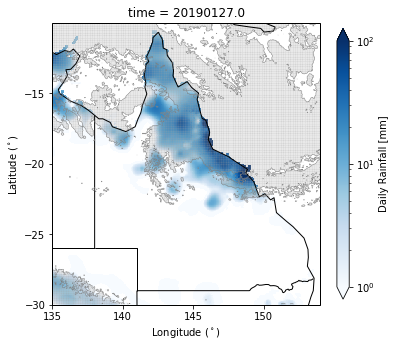

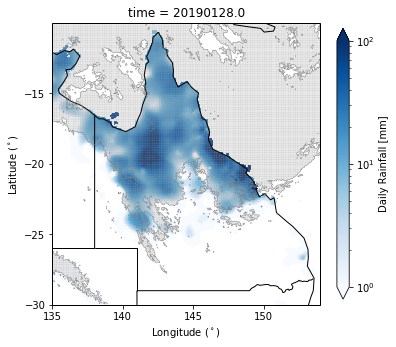

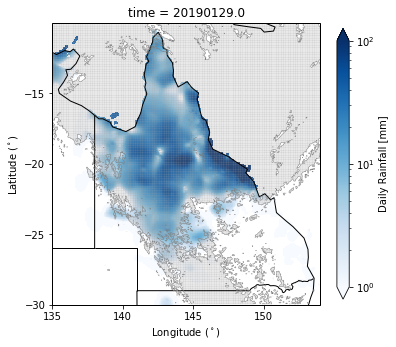

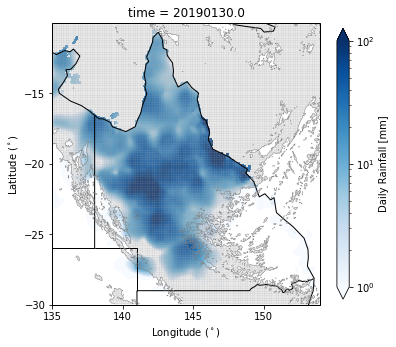

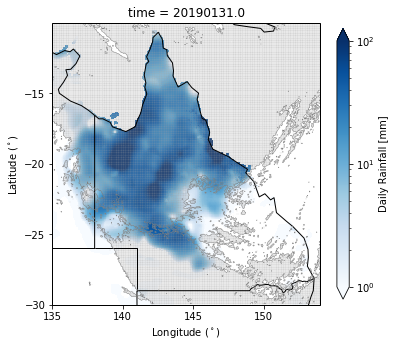

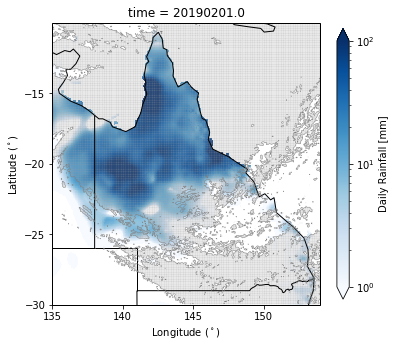

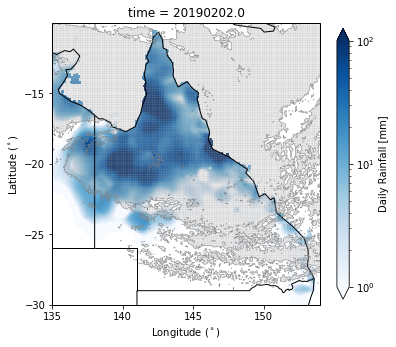

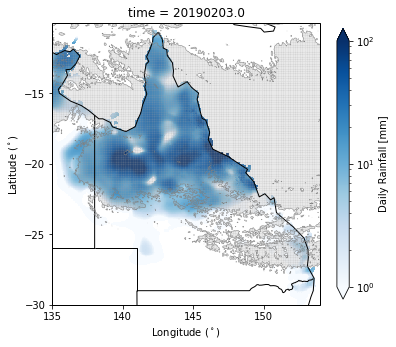

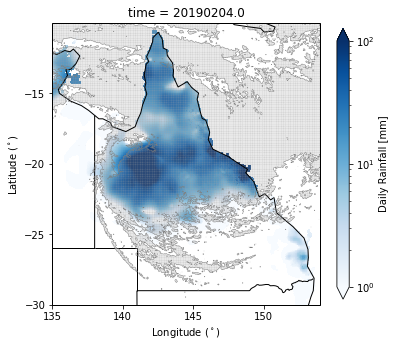

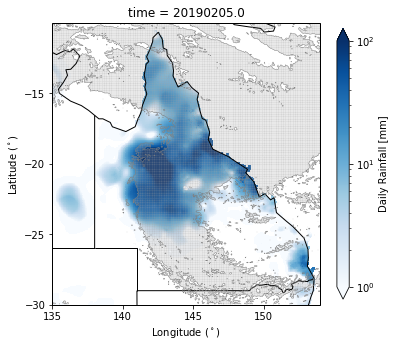

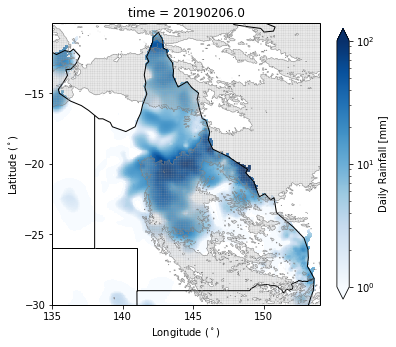

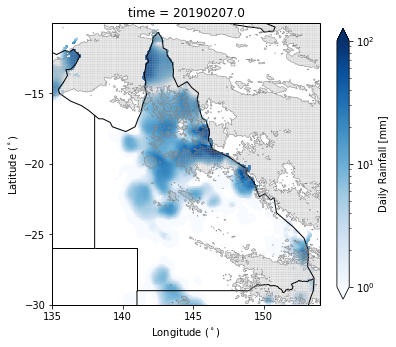

In [23]:
!mkdir qld_anim/
for i in range(len(mask_resamp['time'].values)):
    print(i)
    plot_timestep(i)
    fname = "qld_anim/%03i.png"%i
    plt.savefig(fname)

In [26]:
# resize image to cut off white space, then animate
!mogrify -extent 430x400 -gravity Center qld_anim/*.png
!convert -delay 25 qld_anim/*.png -delay 200 $fname -loop 0 Townsville_mask_awap.gif

In [29]:
!ls qld_anim/*

qld_anim/000.png  qld_anim/004.png  qld_anim/008.png  qld_anim/012.png
qld_anim/001.png  qld_anim/005.png  qld_anim/009.png
qld_anim/002.png  qld_anim/006.png  qld_anim/010.png
qld_anim/003.png  qld_anim/007.png  qld_anim/011.png
